In [57]:
from pyspark import SparkConf
from pyspark.sql import SparkSession
import pyspark.sql.types as t
import pyspark.sql.functions as f
from pyspark.sql import Window
from pyspark.sql import DataFrameStatFunctions as statFunc
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from pprint import pprint

In [58]:
# files = glob('/app/data/*/*.csv')
# files

In [59]:
conf = SparkConf().setAppName('Test') \
                  .set('spark.driver.memory', '2g')\
                  .set('spark.executor.memory', '6g')

spark = SparkSession.builder\
                    .config(conf=conf)\
                    .getOrCreate()

In [60]:
schema = t.StructType([
    t.StructField('record_type', t.StringType()),
    t.StructField('type', t.StringType()),
    t.StructField('time', t.DoubleType()),
    t.StructField('project', t.StringType()),
    t.StructField('collector', t.StringType()),
    t.StructField('router', t.StringType()),
    t.StructField('router_ip', t.StringType()),
    t.StructField('peer_asn', t.IntegerType()),
    t.StructField('peer_address', t.StringType()),
    t.StructField('prefix', t.StringType()),
    t.StructField('next_hop', t.StringType()),
    t.StructField('as_path', t.StringType()),
    t.StructField('communities', t.StringType()),
])

df = spark.read.csv('/app/data/2024-07/1.csv', header=True, schema=schema)

In [61]:
df.show(10)

+-----------+----+-------------------+----------+----------------+------+---------+--------+--------------------+-------------------+--------------------+--------------------+--------------------+
|record_type|type|               time|   project|       collector|router|router_ip|peer_asn|        peer_address|             prefix|            next_hop|             as_path|         communities|
+-----------+----+-------------------+----------+----------------+------+---------+--------+--------------------+-------------------+--------------------+--------------------+--------------------+
|     update|   W|1.720310400067833E9|routeviews|route-views.eqix|  NULL|     NULL|   16552|2001:504:0:2:0:1:...|2a06:de05:626b::/48|                NULL|                NULL|                NULL|
|     update|   W|1.720310400067833E9|routeviews|route-views.eqix|  NULL|     NULL|   16552|2001:504:0:2:0:1:...|2a06:de05:62c5::/48|                NULL|                NULL|                NULL|
|     update|  

In [62]:
start_unixtime = dt.datetime(2024, 7, 7).timestamp()
end_unixtime = dt.datetime(2024, 7, 8).timestamp()

In [63]:
df_period = df.filter((df.time >= start_unixtime) & (df.time < end_unixtime))

In [64]:
# Add time columns
df_enriched = df_period.withColumn('unixtime_second', f.col('time').cast(t.IntegerType()))\
                       .withColumn('datetime', f.from_unixtime('time'))\
                       .withColumn('hour', f.date_trunc('hour', 'datetime'))\
                       .withColumn('minute', f.date_trunc('minute', 'datetime'))

# Add origin
df_enriched = df_enriched.withColumn('as_path_split', f.split('as_path', ' '))\
                       .withColumn(
                           'origin_asn', 
                            f.get('as_path_split', f.size('as_path_split') - 1).cast(t.IntegerType())
                       )\
                       .drop('as_path_split')

# Add convergence periods by timeout
convergence_timeout = 300
peer_prefix_time_window = Window.partitionBy('peer_asn', 'prefix')\
                               .orderBy('time')
df_enriched = df_enriched.withColumn(
                            'peer_prefix_last_time', 
                            f.lag('time').over(peer_prefix_time_window)
                         )\
                         .withColumn(
                             'new_convergence_period', 
                             ((f.col('time') - f.col('peer_prefix_last_time')) > convergence_timeout).cast(t.IntegerType())
                         )\
                         .withColumn(
                             'convergence_period', 
                             f.sum('new_convergence_period').over(peer_prefix_time_window)
                         )

In [65]:
df_convergence = df_enriched.groupBy('hour', 'convergence_period')\
                            .agg((f.max('time') - f.min('time')).alias('convergence_time'))\
                            .groupBy('hour')\
                            .agg(
                                f.mean('convergence_time').alias('mean_convergence_time'),
                                f.std('convergence_time').alias('std_convergence_time'),
                                f.min('convergence_time').alias('min_convergence_time'),
                                f.percentile('convergence_time', 0.25).alias('percentile_convergence_time_25'),
                                f.percentile('convergence_time', 0.5).alias('median_convergence_time'),
                                f.percentile('convergence_time', 0.75).alias('percentile_convergence_time_75'),
                                f.max('convergence_time').alias('max_convergence_time')
                            )

In [66]:
df_hour = df_enriched.groupBy('hour')\
                     .agg(
                         f.countDistinct('peer_asn').alias('unique_peers'),
                         f.countDistinct('origin_asn').alias('unique_origins'),
                         f.countDistinct('prefix').alias('unique_prefixes'),
                         f.count('time').alias('updates')
                     )\
                    .join(df_convergence, on='hour', how='left')\
                    .sort(f.asc('hour'))

In [67]:
df_hour = df_hour.toPandas()

25/04/06 20:10:05 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/06 20:10:05 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/06 20:10:05 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/06 20:10:05 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/06 20:10:05 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/06 20:10:05 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/06 20:10:05 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/06 20:10:05 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/06 20:10:47 WARN RowBasedKeyValueBatch: Calling spill() on

In [31]:
# spark.stop()

In [70]:
df_hour['hour'] = pd.to_datetime(df_hour['hour'])
df_hour

,hour,unique_peers,unique_origins,unique_prefixes,updates,mean_convergence_time,std_convergence_time,min_convergence_time,percentile_convergence_time_25,median_convergence_time,percentile_convergence_time_75,max_convergence_time
0,2024-07-07 00:00:00,26,8128,49625,1378445,2036.867371,1289.372261,1.478903,1346.753780,2119.050876,3077.080627,3599.726131
1,2024-07-07 01:00:00,27,18881,145475,1470129,2425.227579,1535.476100,0.769950,1036.637155,3285.562339,3598.926214,3599.961592
2,2024-07-07 02:00:00,27,20415,130174,1786858,2402.589409,1536.528214,1.325724,608.235415,3369.583061,3588.248012,3599.934501
3,2024-07-07 03:00:00,25,19963,159917,1994061,2333.048244,1584.815078,0.404743,305.975298,3514.786097,3596.692822,3599.954235
4,2024-07-07 04:00:00,26,16025,97834,1428932,2517.310632,1473.054016,0.411212,562.908898,3569.419112,3597.665992,3599.935102
5,2024-07-07 05:00:00,25,16377,83620,1418061,2614.336668,1432.966368,0.413101,1541.087186,3575.994261,3596.322623,3599.947435
6,2024-07-07 06:00:00,26,15272,82100,1357187,2712.989584,1397.778690,0.402023,1285.413178,3582.305021,3587.416907,3599.898129
7,2024-07-07 07:00:00,26,20774,148047,1579616,2843.044984,1257.716340,0.618040,2828.989200,3572.760538,3598.024168,3599.934669
8,2024-07-07 08:00:00,25,7711,40224,1439638,2899.851396,1192.178489,0.405955,2888.567085,3566.768792,3587.184902,3599.857392
9,2024-07-07 09:00:00,25,16147,97964,1419304,2891.214118,1208.198323,0.506592,2925.104589,3544.544094,3597.684443,3599.937558


In [71]:
def plot_metrics_over_time(df: pd.DataFrame, 
                           time_col: str, 
                           figsize: tuple[int] = (15, 7),
                           ncols: int = 2) -> None:
    title = f'BGP Metrics over Time ({time_col.title()})'
    metrics = [col for col in df if col!=time_col]
    nrows = round(len(metrics) / ncols)
    fig, axs = plt.subplots(figsize=figsize, nrows=nrows, ncols=ncols)
    fig.tight_layout() 
    fig.suptitle(title)
    plt.subplots_adjust(top=0.9)
    for i, metric in enumerate(metrics):
        row = i // ncols
        col = i % ncols
        df.plot(x='hour', y=metric, ax=axs[row,col])

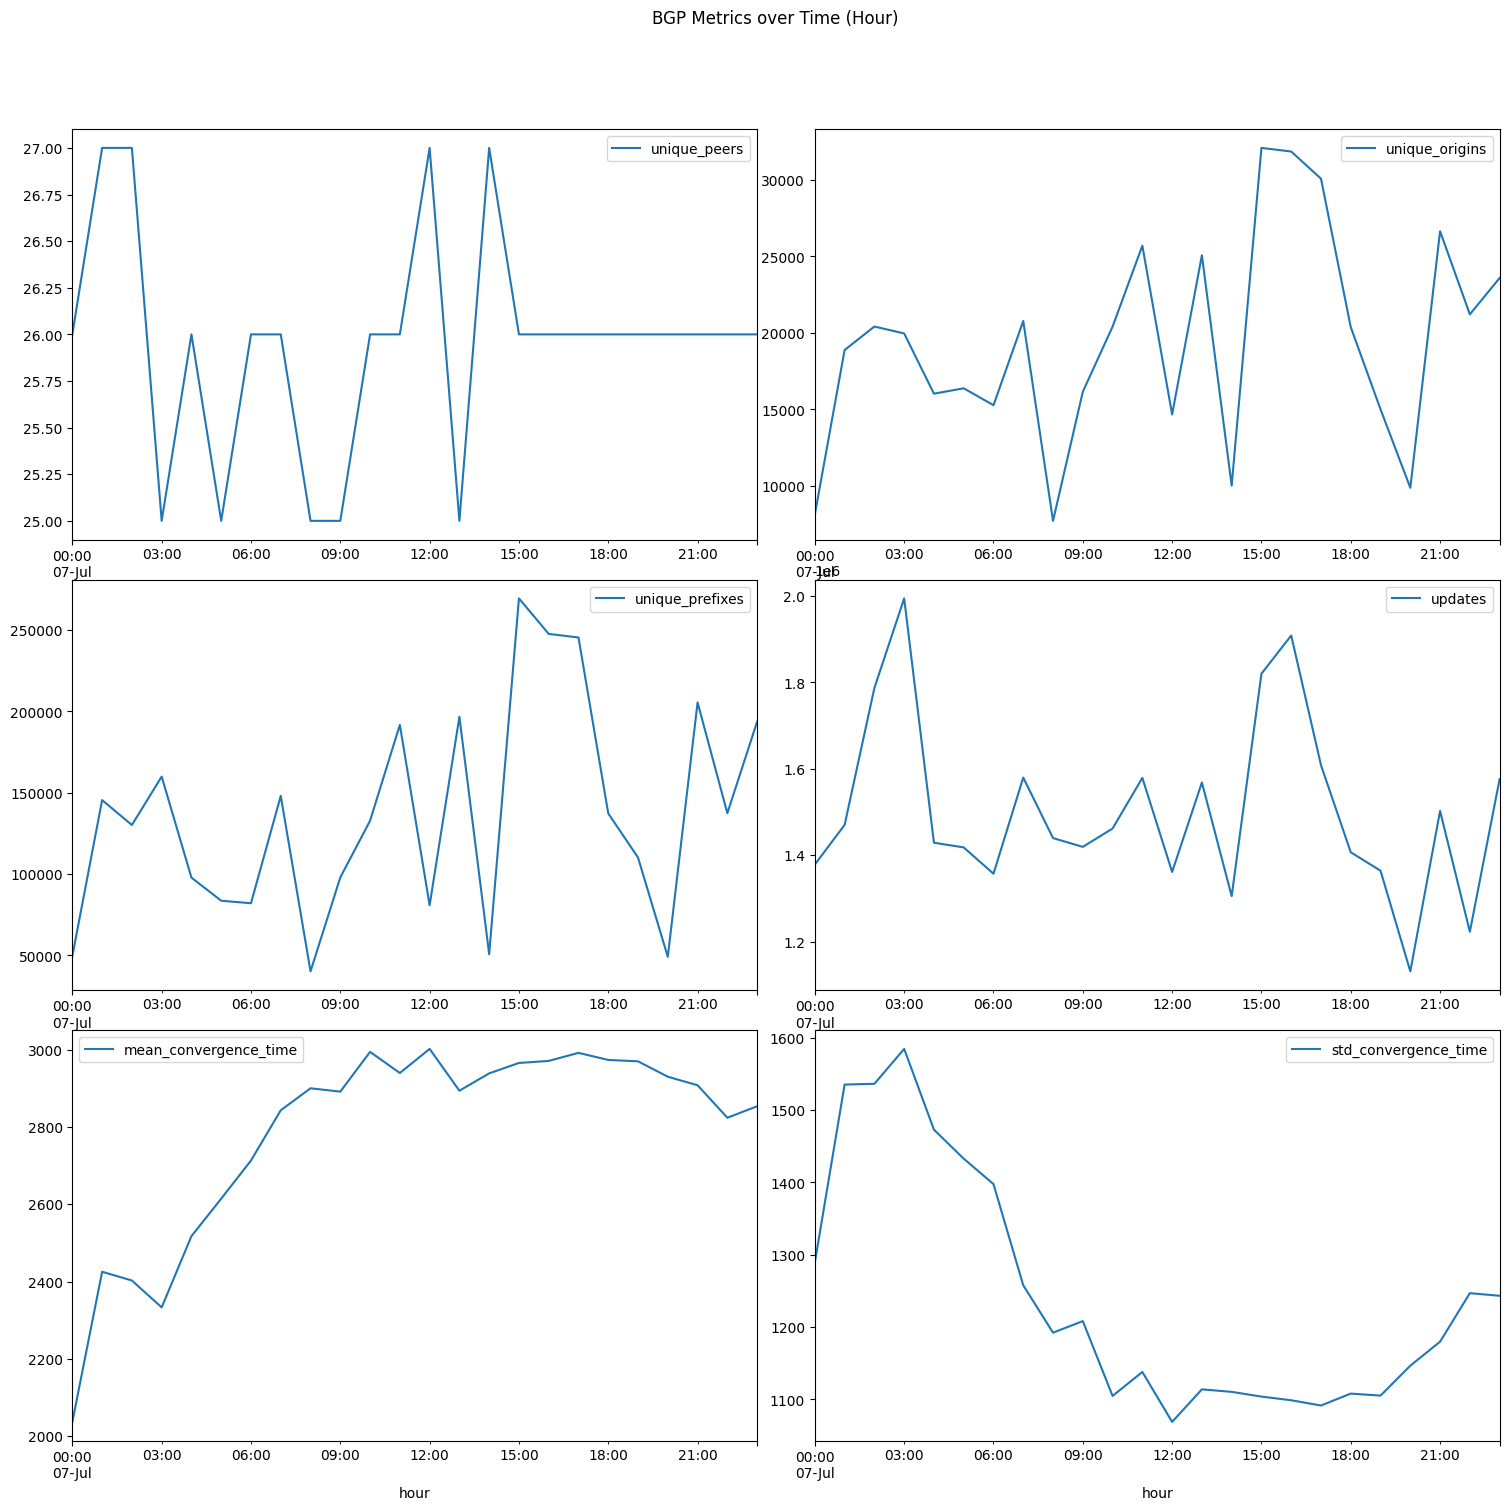

In [76]:
df_hour_ = df_hour[['hour', 'unique_peers', 'unique_origins', 'unique_prefixes', 'updates', 'mean_convergence_time', 'std_convergence_time']]
plot_metrics_over_time(df_hour_, 'hour', figsize=(15, 15))